In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="2eOZiaYbTKlrmCqasL69")
project = rf.workspace("yssp").project("field-xzc0o")
version = project.version(6)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...


In [2]:
import os
import yaml
import cv2
import matplotlib.pyplot as plt
import numpy as np

# データセットのパス
dataset_path = "./field-6"

# data.yamlを読み込み
with open(os.path.join(dataset_path, "data.yaml"), 'r') as f:
    data_config = yaml.safe_load(f)

print("=== データセット情報 ===")
print(f"クラス数: {data_config['nc']}")
print(f"クラス名: {data_config['names']}")

# 各セットの画像数を確認
for split in ['train', 'valid', 'test']:
    img_dir = os.path.join(dataset_path, split, 'images')
    if os.path.exists(img_dir):
        count = len(os.listdir(img_dir))
        print(f"{split}セット: {count}枚")

=== データセット情報 ===
クラス数: 7
クラス名: ['18Yard', '18Yard Circle', '5Yard', 'First Half Central Circle', 'First Half Field', 'Second Half Central Circle', 'Second Half Field']
trainセット: 2523枚
validセット: 161枚
testセット: 101枚



=== クラスID対応表 ===
ID 0: 18Yard
ID 1: 18Yard Circle
ID 2: 5Yard
ID 3: First Half Central Circle
ID 4: First Half Field
ID 5: Second Half Central Circle
ID 6: Second Half Field


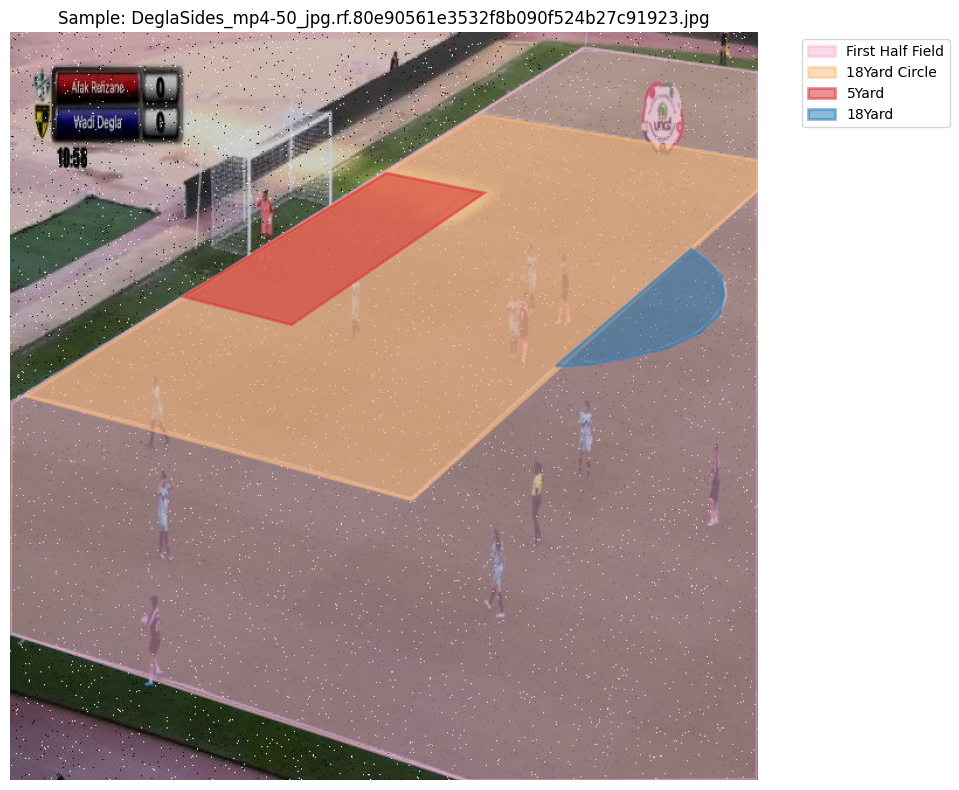

In [3]:
# クラスIDと名前の対応を表示
print("\n=== クラスID対応表 ===")
for idx, name in enumerate(data_config['names']):
    print(f"ID {idx}: {name}")

# サンプル画像とアノテーションを確認
train_images = os.listdir(os.path.join(dataset_path, 'train', 'images'))
sample_image_name = train_images[0]

# 画像を読み込み
img_path = os.path.join(dataset_path, 'train', 'images', sample_image_name)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ラベルファイルを読み込み
label_name = sample_image_name.replace('.jpg', '.txt').replace('.png', '.txt')
label_path = os.path.join(dataset_path, 'train', 'labels', label_name)

# 可視化
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img_rgb)

# セグメンテーションマスクを描画
colors = plt.cm.tab20(np.linspace(0, 1, len(data_config['names'])))

with open(label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        class_id = int(parts[0])
        
        # ポリゴン座標（正規化されている）
        coords = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)
        
        # 画像サイズに合わせてスケール
        h, w = img.shape[:2]
        coords[:, 0] *= w
        coords[:, 1] *= h
        
        # ポリゴンを描画
        from matplotlib.patches import Polygon
        poly = Polygon(coords, alpha=0.5, 
                      facecolor=colors[class_id],
                      edgecolor=colors[class_id],
                      linewidth=2,
                      label=f"{data_config['names'][class_id]}")
        ax.add_patch(poly)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(f"Sample: {sample_image_name}")
ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# 全ラベルファイルからクラス分布を集計
from collections import Counter

class_counts = Counter()
total_polygons = 0

label_dir = os.path.join(dataset_path, 'train', 'labels')
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
                    total_polygons += 1

print(f"\n=== クラス分布（訓練セット）===")
print(f"総ポリゴン数: {total_polygons}")
for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    class_name = data_config['names'][class_id]
    percentage = (count / total_polygons) * 100
    print(f"{class_id}: {class_name:<30} {count:>6}個 ({percentage:>5.1f}%)")


=== クラス分布（訓練セット）===
総ポリゴン数: 11117
0: 18Yard                           1941個 ( 17.5%)
1: 18Yard Circle                    1834個 ( 16.5%)
2: 5Yard                            1484個 ( 13.3%)
3: First Half Central Circle        1158個 ( 10.4%)
4: First Half Field                 1797個 ( 16.2%)
5: Second Half Central Circle       1195個 ( 10.7%)
6: Second Half Field                1708個 ( 15.4%)


In [5]:
import torch
import platform

print("=== システム情報 ===")
print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")
print(f"MPS利用可能: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

if torch.backends.mps.is_available():
    print("\n✅ MPSが利用可能です！")
    # テスト
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(f"MPSテスト成功: {x}")
else:
    print("\n❌ MPSが利用できません")

=== システム情報 ===
Python version: 3.11.13
PyTorch version: 2.7.1
MPS利用可能: True
MPS built: True

✅ MPSが利用可能です！
MPSテスト成功: tensor([1.], device='mps:0')


In [ ]:
import os
import yaml
import torch
from ultralytics import YOLO
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import psutil
import warnings

class YOLOv8MPSTrainerOptimized:
    """メモリ自動検出とGPU最適化を両立したYOLOv8学習"""
    
    def __init__(self, dataset_path: str):
        self.dataset_path = os.path.abspath(dataset_path)
        self.total_memory_gb = psutil.virtual_memory().total / (1024**3)
        self.device = self._setup_device()
        self.data_config = self._prepare_data_config()
        
        # 環境変数設定（シンプルに必要最小限）
        if self.device == 'mps':
            os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
            os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        
        # 警告を抑制
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        
    def _setup_device(self):
        """デバイスの設定と情報表示（シンプル版）"""
        if torch.backends.mps.is_available():
            device = 'mps'
            print("✅ Apple Silicon GPU (MPS) を使用します")
            print(f"💾 メモリ: {self.total_memory_gb:.1f} GB")
        elif torch.cuda.is_available():
            device = 'cuda'
            print("✅ CUDA GPU を使用します")
            print(f"GPU: {torch.cuda.get_device_name(0)}")
        else:
            device = 'cpu'
            print("⚠️ GPUが利用できないため、CPUを使用します")
        return device
    
    def _prepare_data_config(self):
        """データ設定の準備（シンプル版）"""
        with open(os.path.join(self.dataset_path, "data.yaml"), 'r') as f:
            data_config = yaml.safe_load(f)
        
        data_config['path'] = self.dataset_path
        
        temp_yaml_path = f'field_data_{int(self.total_memory_gb)}gb.yaml'
        with open(temp_yaml_path, 'w') as f:
            yaml.dump(data_config, f)
        
        return temp_yaml_path
    
    def get_optimal_batch_size(self, model_size='m', imgsz=640):
        """メモリに基づく最適なバッチサイズ（高速計算版）"""
        # メモリサイズに応じたバッチサイズマップ
        if self.total_memory_gb >= 64:
            batch_map = {
                'n': 32, 's': 24, 'm': 16, 'l': 12, 'x': 8
            }
        elif self.total_memory_gb >= 32:
            batch_map = {
                'n': 24, 's': 16, 'm': 12, 'l': 8, 'x': 4
            }
        elif self.total_memory_gb >= 16:
            batch_map = {
                'n': 16, 's': 12, 'm': 8, 'l': 4, 'x': 2
            }
        else:
            batch_map = {
                'n': 8, 's': 6, 'm': 4, 'l': 2, 'x': 1
            }
        
        # 画像サイズによる調整
        size_factor = (640 / imgsz) ** 2
        batch_size = int(batch_map[model_size] * size_factor)
        
        return max(1, batch_size)
    
    def get_auto_model_size(self):
        """メモリに基づくモデルサイズの自動選択"""
        if self.total_memory_gb >= 64:
            return 'l'
        elif self.total_memory_gb >= 32:
            return 'm'
        elif self.total_memory_gb >= 16:
            return 's'
        else:
            return 'n'
    
    def train_fast(self, 
                   model_size='auto',
                   epochs=100,
                   imgsz=640,
                   batch_size=None,
                   cache=None,
                   patience=20,
                   **kwargs):
        """高速学習の実行（最小限の自動設定）"""
        
        # モデルサイズの自動選択
        if model_size == 'auto':
            model_size = self.get_auto_model_size()
            print(f"メモリ {self.total_memory_gb:.1f}GB → モデルサイズ '{model_size}' を選択")
        
        # バッチサイズの自動設定
        if batch_size is None:
            batch_size = self.get_optimal_batch_size(model_size, imgsz)
        
        # キャッシュの自動設定
        if cache is None:
            cache = 'ram' if self.total_memory_gb >= 32 else False
        
        # ワーカー数（シンプルな計算）
        workers = min(8, psutil.cpu_count() - 2) if self.total_memory_gb >= 16 else 0
        
        print(f"\n=== YOLOv8{model_size}-seg 高速学習 ===")
        print(f"バッチサイズ: {batch_size}")
        print(f"ワーカー数: {workers}")
        print(f"キャッシュ: {cache}")
        
        # モデル初期化
        model = YOLO(f'yolov8{model_size}-seg.pt')
        
        # 学習パラメータ（必要最小限）
        training_args = {
            'data': self.data_config,
            'epochs': epochs,
            'imgsz': imgsz,
            'batch': batch_size,
            'device': self.device,
            'patience': patience,
            'save': True,
            'project': 'runs/segment',
            'name': f'field_seg_fast_{model_size}_{datetime.now().strftime("%Y%m%d_%H%M%S")}',
            'exist_ok': False,
            'pretrained': True,
            
            # 最適化設定
            'optimizer': 'AdamW',
            'lr0': 0.01,
            'lrf': 0.01,
            'momentum': 0.937,
            'weight_decay': 0.0005,
            
            # パフォーマンス設定
            'cache': cache,
            'workers': workers,
            'amp': False if self.device == 'mps' else True,
            
            # 基本的なデータ拡張のみ
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4,
            'translate': 0.1,
            'scale': 0.5,
            'fliplr': 0.5,
            'mosaic': 1.0,
            
            # その他
            'verbose': True,
            'seed': 42,
            'deterministic': True,
            'rect': False,
            'close_mosaic': 10,
            
            # 検証設定
            'val': True,
            'plots': True,
            'conf': 0.001,
            'iou': 0.7,
            'max_det': 300,
        }
        
        # kwargsで上書き可能
        training_args.update(kwargs)
        
        # 学習実行
        print("\n🚀 学習を開始します...")
        try:
            results = model.train(**training_args)
            print("\n✅ 学習が完了しました！")
            
            best_model_path = Path(results.save_dir) / 'weights' / 'best.pt'
            
            # 結果のプロット（シンプル版）
            self._plot_results_simple(results)
            
            return best_model_path, results
            
        except Exception as e:
            print(f"\n❌ エラー: {e}")
            if "out of memory" in str(e).lower():
                print(f"💡 バッチサイズを {batch_size // 2} に減らしてみてください")
            raise
    
    def _plot_results_simple(self, results):
        """結果の簡易プロット"""
        results_csv = Path(results.save_dir) / 'results.csv'
        if results_csv.exists():
            print(f"📊 結果は以下に保存されました: {results.save_dir}")
            print(f"   - 学習曲線: {results.save_dir}/results.png")
            print(f"   - 混同行列: {results.save_dir}/confusion_matrix.png")
    
    def benchmark_speed(self, model_path: str, test_images_dir: str, num_images=10):
        """高速ベンチマーク"""
        import time
        
        model = YOLO(model_path)
        test_images = list(Path(test_images_dir).glob('*.jpg'))[:num_images]
        
        if not test_images:
            print(f"⚠️ テスト画像が見つかりません")
            return
        
        # ウォームアップ
        for _ in range(3):
            model(test_images[0], device=self.device, verbose=False)
        
        # 計測
        start = time.time()
        for img in test_images:
            model(img, device=self.device, verbose=False)
        
        total_time = time.time() - start
        avg_time = (total_time / len(test_images)) * 1000
        fps = 1000 / avg_time
        
        print(f"\n📊 推論速度:")
        print(f"  - 平均: {avg_time:.1f} ms/画像")
        print(f"  - FPS: {fps:.1f}")


# より簡潔な実行スクリプト
if __name__ == "__main__":
    # トレーナー初期化
    trainer = YOLOv8MPSTrainerOptimized(dataset_path="./field-6")
    
    # シンプルな実行（完全自動）
    model_path, _ = trainer.train_fast(
        # model_size='auto',  # 自動選択
        model_size='n',  # 手動指定
        epochs=30,          # お試し用 1→30ぐらいにするといい
        imgsz=640,
    )
    
    # または手動設定
    # model_path, _ = trainer.train_fast(
    #     model_size='m',     # 手動指定
    #     epochs=100,
    #     batch_size=16,      # 手動指定
    #     cache='ram',        # 手動指定
    # )
    
    # ベンチマーク
    test_dir = "./field-6/test/images"
    if Path(test_dir).exists():
        trainer.benchmark_speed(str(model_path), test_dir)

✅ Apple Silicon GPU (MPS) を使用します
💾 メモリ: 64.0 GB

=== YOLOv8n-seg 高速学習 ===
バッチサイズ: 32
ワーカー数: 8
キャッシュ: ram

🚀 学習を開始します...
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.7.1 MPS (Apple M4 Max)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.001, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=field_data_64gb.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=field_seg_fast_n_20250803_042201, nbs=64, nms=False, o

train: Scanning /Users/rn/Documents/FC/Text2Field/field-6/train/labels.cache... 2523 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2523/2523 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.9GB RAM): 100%|██████████| 2523/2523 [00:00<00:00, 2890.82it/s]

val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 510.3±233.1 MB/s, size: 129.0 KB)



val: Scanning /Users/rn/Documents/FC/Text2Field/field-6/valid/labels.cache... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 161/161 [00:00<00:00, 2363.54it/s]


Plotting labels to runs/segment/field_seg_fast_n_20250803_042201/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/field_seg_fast_n_20250803_042201
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/1      10.5G      0.825      1.605      1.722      1.132        310        640: 100%|██████████| 79/79 [02:32<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting va

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:21<00:42, 21.45s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting va

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:34<00:16, 16.60s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting va

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:47<00:00, 15.79s/it]


                   all        161        705     0.0258     0.0656     0.0186     0.0072      0.018     0.0485     0.0147    0.00404

1 epochs completed in 0.056 hours.
Optimizer stripped from runs/segment/field_seg_fast_n_20250803_042201/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/field_seg_fast_n_20250803_042201/weights/best.pt, 6.8MB

Validating runs/segment/field_seg_fast_n_20250803_042201/weights/best.pt...
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.7.1 MPS (Apple M4 Max)
YOLOv8n-seg summary (fused): 85 layers, 3,259,429 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting va

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:12<00:24, 12.19s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting va

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:21<00:10, 10.63s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting va

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:30<00:00, 10.16s/it]


                   all        161        705     0.0243     0.0978     0.0224    0.00816     0.0173     0.0747     0.0152    0.00419
                18Yard        137        138     0.0327      0.275     0.0386     0.0139     0.0249       0.21     0.0304    0.00636
         18Yard Circle        125        126    0.00199     0.0397    0.00553    0.00305    0.00159     0.0317    0.00413    0.00186
                 5Yard        106        107          0          0     0.0156     0.0074          0          0    0.00359     0.0011
First Half Central Circle         63         64          0          0    0.00245    0.00102          0          0    0.00128   0.000299
      First Half Field        113        113      0.022      0.142     0.0147    0.00499     0.0206      0.133     0.0131    0.00393
Second Half Central Circle         55         56          0          0    0.00109   0.000235          0          0   0.000899   0.000261
     Second Half Field        100        101      0.113      0